In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os

Using TensorFlow backend.


In [2]:
import zipfile

zip_files = ['test1', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("E:\ML Projects\dogs cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [3]:
filenames = os.listdir(r"E:\ML Projects\dogs cats\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


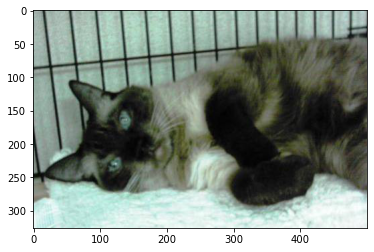

In [4]:
sample = random.choice(filenames)
image = load_img(r"E:\ML Projects\dogs cats\train/"+sample)
plt.imshow(image)

In [5]:
width=128
height=128
size=(width,height)
channels=3

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

In [7]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(width,height,channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
earlystop = EarlyStopping(patience=5)

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
callbacks = [earlystop, learning_rate_reduction]

In [12]:
train_df,validate_df=train_test_split(df,test_size=0.2,random_state=4)
train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)

In [13]:
train_df.head()

,filename,category
0,cat.9241.jpg,0
1,dog.2606.jpg,1
2,cat.11159.jpg,0
3,cat.2643.jpg,0
4,dog.7894.jpg,1


In [14]:
train_df['category'].value_counts()

0    10022
1     9978
Name: category, dtype: int64

In [15]:
import tensorflow as tf
train_df['category']=train_df['category'].astype('str')
validate_df['category']=validate_df['category'].astype('str')

In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"E:\ML Projects\dogs cats\train", 
    x_col='filename',
    y_col='category',
    target_size=size,
    class_mode='categorical',
    batch_size=15
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"E:\ML Projects\dogs cats\train", 
    x_col='filename',
    y_col='category',
    target_size=size,
    class_mode='categorical',
    batch_size=20
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
callbacks=[earlystop, learning_rate_reduction]

In [18]:
epochs=15
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//20,
    steps_per_epoch=total_train//20,
    callbacks=callbacks
)

Epoch 1/15
1000/1000 [==============================] - 1411s 1s/step - loss: 0.7997 - accuracy: 0.6045 - val_loss: 0.5806 - val_accuracy: 0.6874
Epoch 2/15
1000/1000 [==============================] - 1133s 1s/step - loss: 0.6149 - accuracy: 0.6711 - val_loss: 0.4690 - val_accuracy: 0.6444
Epoch 3/15
1000/1000 [==============================] - 1115s 1s/step - loss: 0.5750 - accuracy: 0.7067 - val_loss: 0.6738 - val_accuracy: 0.7406
Epoch 4/15
1000/1000 [==============================] - 1068s 1s/step - loss: 0.5416 - accuracy: 0.7305 - val_loss: 0.5985 - val_accuracy: 0.7342
Epoch 5/15
1000/1000 [==============================] - 2338s 2s/step - loss: 0.5300 - accuracy: 0.7399 - val_loss: 0.5286 - val_accuracy: 0.7232
Epoch 6/15
1000/1000 [==============================] - 1138s 1s/step - loss: 0.5289 - accuracy: 0.7439 - val_loss: 0.7558 - val_accuracy: 0.6432

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/15
1000/1000 [=====================

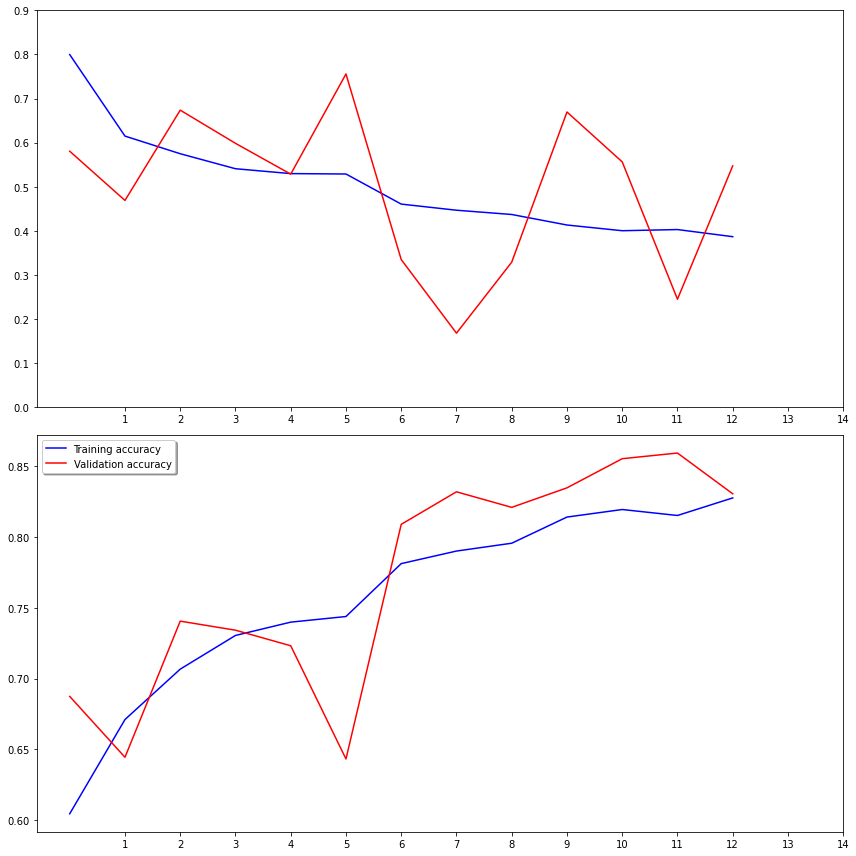

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()